In [25]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import copy

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages
from gempyor.utils import config, as_list
import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
import xarray as xr
from gempyor import config, model_info, outcomes, seir, inference_parameter, logloss, inference
from gempyor.inference import GempyorInference
import gempyor.postprocess_inference
import multiprocessing, shutil

import os
from multiprocessing import cpu_count

# disable  operations using the MKL linear algebra.
os.environ["OMP_NUM_THREADS"] = "1"
import emcee

from multiprocessing import Pool

## Test A
project_path = "./flepiMoP/examples/simple_usa_statelevel/"  # necessary for now for time serie parameters !!! FIXME
config_filepath = f"simple_usa_statelevel.yml"
seir_modifiers_scenario="Ro_all"
outcome_modifiers_scenario=None

# Test B
project_path = "RSV_USA/"
config_filepath = f"config_rsvnet_emcee.yml"
#seir_modifiers_scenario="none"
#outcome_modifiers_scenario="IHRadj"

# Test C
#project_path = "COVID19_USA/"
#config_filepath= "config_SMH_R18_allBoo_highIE_blk1_emcee.yml"
#config_filepath="config_FCH_R17_allBoo_highIE_phase5_blk1_21Apr2024.yml"

# Flu SMH
project_path = "Flu_USA/"
config_filepath = f"config_SMH_Flu_2024_R1_allflu_medVax_H3_training_emcee.yml"
seir_modifiers_scenario="none"
outcome_modifiers_scenario="fake"

project_path = "COVID19_Disparities"
config_filepath = f"config_SMH_Rdisparity_phase_one_phase1_blk1_limitIFR_CA-NC_emcee.yml"
seir_modifiers_scenario="inference"
outcome_modifiers_scenario="all"

nwalkers = 3
niter = 4
nsamples = 50 # number of likelyhood eval to write to disk...
nthin=5
run_id = "SMH_Rdisparity_phase_one_phase1_blk1_limitIFR_CA-NC_emcee"

#### START COPY PAST FROM flepiMoP/flepimop/gempyor_pkg/src/gempyor/calibrate.py
ncpu = cpu_count()
print(f"found {ncpu} CPUs, using these")

gempyor_inference = GempyorInference(
        config_filepath=config_filepath,
        run_id=run_id,
        prefix=None,
        first_sim_index=1,
        stoch_traj_flag=False,
        rng_seed=None,
        nslots=1,
        inference_filename_prefix="global/final/",  # usually for {global or chimeric}/{intermediate or final}
        inference_filepath_suffix="",  # usually for the slot_id
        out_run_id=None,  # if out_run_id is different from in_run_id, fill this
        out_prefix=None,  # if out_prefix is different from in_prefix, fill this
        path_prefix=project_path,  # in case the data folder is on another directory
        autowrite_seir=False,
)
#inferpar = inference_parameter.InferenceParameters(global_config=config, modinf=modinf)
p0 = gempyor_inference.inferpar.draw_initial(n_draw=nwalkers)
for i in range(nwalkers):
    assert  gempyor_inference.inferpar.check_in_bound(proposal=p0[i]), "The initial parameter draw is not within the bounds, check the perturbation distributions"

nsubpop = len(gempyor_inference.modinf.subpop_struct.subpop_names)
subpop_names = gempyor_inference.modinf.subpop_struct.subpop_names


print(gempyor_inference.logloss)
print(gempyor_inference.inferpar)

found 12 CPUs, using these
  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> ModelInfo USA_inference_all; index: 1; run_id: SMH_Rdisparity_phase_one_phase1_blk1_re_npis_CA-NC_emcee,
  gempyor >> prefix: USA_inference_all/SMH_Rdisparity_phase_one_phase1_blk1_re_npis_CA-NC_emcee/;
Loaded subpops in loaded relative probablity file: 51 Intersect with seir simulation:  2 kept
Running Gempyor Inference
LogLoss: 5 statistics and 92 data points,number of NA for each statistic: 
incidC_latino    62
incidC_other     25
incidC_asian     25
incidC_black     25
incidC_white     25
incidD_latino    46
incidD_other      0
incidD_asian      0
incidD_black      0
incidD_white      0
dtype: int64
InferenceParameters: with 78 parameters: 
    seir_modifiers: 68 parameters
    outcome_modifiers: 10 parameters

LogLoss: 5 statistics and 92 data points,number of NA for each statistic: 
incidC_latino    62
incidC_other     25
incidC_asian     25
incidC_black     25
incidC_white     25
incidD_

In [2]:
gempyor_inference.modinf.compartments.transitions

,source,destination,rate,proportional_to,proportion_exponent
0,"[S, unvaccinated, WILD, age0to17, latino]","[E, unvaccinated, WILD, age0to17, latino]","[r0*gamma*phi_latino, 1, 1, 1, phi_latino]","[[[S], [unvaccinated], [WILD], [age0to17], [la...","[[1, 1, 1, 1, 1], [alpha, 1, 1, 1, 1]]"
1,"[S, unvaccinated, WILD, age0to17, latino]","[E, unvaccinated, WILD, age0to17, latino]","[r0*gamma*phi_latino, 1, 1, 1, phi_black]","[[[S], [unvaccinated], [WILD], [age0to17], [la...","[[1, 1, 1, 1, 1], [alpha, 1, 1, 1, 1]]"
2,"[S, unvaccinated, WILD, age0to17, latino]","[E, unvaccinated, WILD, age0to17, latino]","[r0*gamma*phi_latino, 1, 1, 1, phi_white]","[[[S], [unvaccinated], [WILD], [age0to17], [la...","[[1, 1, 1, 1, 1], [alpha, 1, 1, 1, 1]]"
3,"[S, unvaccinated, WILD, age0to17, latino]","[E, unvaccinated, WILD, age0to17, latino]","[r0*gamma*phi_latino, 1, 1, 1, phi_asian]","[[[S], [unvaccinated], [WILD], [age0to17], [la...","[[1, 1, 1, 1, 1], [alpha, 1, 1, 1, 1]]"
4,"[S, unvaccinated, WILD, age0to17, latino]","[E, unvaccinated, WILD, age0to17, latino]","[r0*gamma*phi_latino, 1, 1, 1, phi_other]","[[[S], [unvaccinated], [WILD], [age0to17], [la...","[[1, 1, 1, 1, 1], [alpha, 1, 1, 1, 1]]"
...,...,...,...,...,...
4435,"[W, 2dose, ALPHA, age65to100, latino]","[W, waned, ALPHA, age65to100, latino]","[1, epsilon, 1, 1, 1]","[[[W], [2dose], [ALPHA], [age65to100], [latino]]]","[[1, 1, 1, 1, 1]]"
4436,"[W, 2dose, ALPHA, age65to100, black]","[W, waned, ALPHA, age65to100, black]","[1, epsilon, 1, 1, 1]","[[[W], [2dose], [ALPHA], [age65to100], [black]]]","[[1, 1, 1, 1, 1]]"
4437,"[W, 2dose, ALPHA, age65to100, white]","[W, waned, ALPHA, age65to100, white]","[1, epsilon, 1, 1, 1]","[[[W], [2dose], [ALPHA], [age65to100], [white]]]","[[1, 1, 1, 1, 1]]"
4438,"[W, 2dose, ALPHA, age65to100, asian]","[W, waned, ALPHA, age65to100, asian]","[1, epsilon, 1, 1, 1]","[[[W], [2dose], [ALPHA], [age65to100], [asian]]]","[[1, 1, 1, 1, 1]]"


In [ ]:
gempyor_inference.modinf.compartments.toFile()
gempyor.read_df("transitions.parquet")

In [2]:
outcome_df = gempyor_inference.simulate_proposal(p0[0])

In [21]:
ll_total, logloss, regularizations = gempyor_inference.logloss.compute_logloss(
            model_df=outcomes_df, subpop_names=gempyor_inference.modinf.subpop_struct.subpop_names
        )

/Users/chadi/anaconda3/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [17]:
filename = f"{run_id}_backend.h5"
sampler = emcee.backends.HDFBackend(filename, read_only=True) 

In [26]:
filename = "COVID19_Disparities/COVID19_Disparities/calib_Disparities_small_backend.h5"
filename = "COVID19_Disparities/calib_Displocal_backend.h5"
filename = "COVID19_Disparities/COVID19_Disparities/calib_Disparities_backend.h5"
#filename = "COVID19_Disparities/COVID19_Disparities/calib_Disparities_small_backend.h5"

# run_id = filename.split("/")[-1].split(".")[0] # auto_detect run_id
sampler = emcee.backends.HDFBackend(filename, read_only=True)

nsamples=10
chain_index = -1 # -1 for last
chain_index = 4730

max_indices = np.argsort(sampler.get_log_prob()[chain_index, :])[-nsamples:]
chains = sampler.get_chain()[:chain_index, max_indices, :]        # the last iteration, for selected slots
llik = sampler.get_log_prob()[:chain_index, max_indices]

gempyor.postprocess_inference.plot_chains(
        inferpar=gempyor_inference.inferpar, chains=chains, llik=llik, sampled_slots=None, save_to=f"{run_id}_chains2.pdf"
    )
print("EMCEE Run done, doing sampling")

generating chain plot


100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

EMCEE Run done, doing sampling


In [3]:
sampler.get_chain().shape

(5758, 500, 78)

In [27]:
shutil.rmtree("model_output/", ignore_errors=True)
shutil.rmtree(project_path + "/model_output/", ignore_errors=True)

samples = sampler.get_chain()[chain_index, max_indices, :]  # the last iteration, for selected slots
gempyor_inference.set_save(True)
with multiprocessing.Pool(ncpu) as pool:
    results = pool.starmap(
        gempyor_inference.get_logloss_as_single_number, [(samples[i, :],) for i in range(len(max_indices))]
    )

In [49]:
results = []
for fn in gempyor.utils.list_filenames(folder=project_path+"/model_output/", filters=["hosp.parquet"]): ## TODO: here project path is correct, but use to concatenate path. the right way
   df = gempyor.read_df(fn)
   df = df.set_index("date")
   results.append(df)
print(len(results))

10


In [50]:
def plot_fit(modinf, inferpar, loss, list_of_df, save_to):
    with PdfPages(f"{save_to}") as pdf:
            d = pdf.infodict()
            d["Title"] = "FlepiMoP Inference Fit"
            d["Author"] = "FlepiMoP Inference"
            

            for j, subpop in enumerate(modinf.subpop_struct.subpop_names):
                fig, axes = plt.subplots(1, len(loss.statistics), figsize=(3 * len(loss.statistics), 4), sharex=True)
                
                gt_s = loss.gt[loss.gt["subpop"] == subpop].sort_index()
                first_date = max(gt_s.index.min(), list_of_df[0].index.min())
                last_date = min(gt_s.index.max(), list_of_df[0].index.max())
                gt_s = gt_s.loc[first_date:last_date].drop(["subpop"], axis=1).resample("W-SAT").sum()

                for i, (stat_name, stat) in enumerate(loss.statistics.items()):
                    ax = axes[i]
                    ax.plot(gt_s[stat.data_var], color="k", marker=".", lw=1)
                    #transformed_gt = stat.apply_transforms(gt_s[stat.data_var].to_xarray())
                    #ax.plot(transformed_gt.date, transformed_gt, color="k", marker=".", lw=1)
                    for model_df in list_of_df:

                        model_df_s = (
                            model_df[model_df["subpop"] == subpop]
                            .drop(["subpop"], axis=1)
                            #.loc[first_date:last_date]
                            .resample("W-SAT")
                            .sum()
                        )  # todo sub subpop here
                        ax.plot(model_df_s[stat.sim_var], lw=0.9, alpha=0.5)
                        #transformed_model = stat.apply_transforms(model_df_s[stat.sim_var].to_xarray())
                        #ax.plot(transformed_model.date,  transformed_model, lw=0.9, alpha=0.5)

                    # if True:
                    #        init_df_s = outcomes_df_ref[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                    ax.set_title(f"{stat_name}, {subpop}")

                # makde date readable:
                fig.autofmt_xdate()
                fig.tight_layout()
                pdf.savefig(fig)
                plt.close(fig)

gempyor.postprocess_inference.plot_fit(modinf=gempyor_inference.modinf, loss=gempyor_inference.logloss, list_of_df=results, save_to=f"{run_id}_fit_grempyor.pdf")
plot_fit(modinf=gempyor_inference.modinf, inferpar=gempyor_inference.inferpar, loss=gempyor_inference.logloss, list_of_df=results, save_to=f"{run_id}_fit_notebook.pdf")

In [172]:
from importlib import reload
gempyor = reload(gempyor)

# plot $R_t$

In [40]:
to_plot="snpi"

results_fn = []
for fn in gempyor.utils.list_filenames(folder=project_path+"/model_output/", filters=[to_plot+".parquet"]): ## TODO: here project path is correct, but use to concatenate path. the right way
    results_fn.append(fn)
print(len(results_fn))

all_parsed_params = []
for fn in results_fn:
    if False:
        p_draw = run_info.gempyor_inference.modinf.parameters.parameters_quick_draw(n_days=run_info.gempyor_inference.modinf.n_days, nsubpops=run_info.gempyor_inference.modinf.nsubpops)
        npi_seir = gempyor.seir.build_npi_SEIR(modinf=run_info.gempyor_inference.modinf, load_ID=False, sim_id2load=None, config=config)
    else:
        p_draw = gempyor_inference.get_seir_parameters(bypass_FN=fn.replace("snpi", "spar"), load_ID=True)
        npi_seir = gempyor.seir.build_npi_SEIR(modinf=gempyor_inference.modinf, load_ID=True, bypass_FN=fn, sim_id2load=None, config=None)
    parameters = gempyor_inference.modinf.parameters.parameters_reduce(p_draw, npi_seir)
    parsed_parameters = gempyor_inference.modinf.compartments.parse_parameters(parameters, gempyor_inference.modinf.parameters.pnames, gempyor_inference.static_sim_arguments["unique_strings"])
    all_parsed_params.append(parsed_parameters)

10


In [47]:
pdf = PdfPages(f'Unique Parsed Parameter for {run_id}.pdf')
d = pdf.infodict()
d["Title"] = "parsed parameters"
d["Author"] = "jlemaitre"
import tqdm

for k,uniq_pname in tqdm.tqdm(enumerate(gempyor_inference.static_sim_arguments["unique_strings"])):
    if True:#'r0*gamma*theta1*1*chi_OMICRON*1' in uniq_pname:
        fig, axes = plt.subplots(len(gempyor_inference.modinf.subpop_struct.subpop_names), 1, 
                                figsize=(10, len(gempyor_inference.modinf.subpop_struct.subpop_names)*3), 
                                sharex=True, sharey=True)
        fig.suptitle(uniq_pname, fontsize=22)
        #print(uniq_pname)
        for i, geoid in enumerate(gempyor_inference.modinf.subpop_struct.subpop_names):
            ax = axes.flat[i]
            ax.set_title(geoid)
            ax.grid()
            for l in range(len(all_parsed_params)):
                df = pd.DataFrame(all_parsed_params[l][k,:,i], index=pd.date_range(gempyor_inference.modinf.ti, 
                                                                                gempyor_inference.modinf.tf, 
                                                                                freq="D"))
                ax.plot(df, lw=.5) #df[:'2021-12-31']
            fig.autofmt_xdate()
        fig.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
pdf.close()

497it [01:23,  5.95it/s]


In [ ]:
samples = sampler.get_chain()[-1,max_indices ,:]
a = [(samples[i,:],) for i in range(len(max_indices))]

In [ ]:
simulation_atomic(**ss, modinf=self.modinf, save=self.save)

# manual injection to understand the parameters

In [2]:
p0 = gempyor_inference.inferpar.draw_initial(n_draw=nwalkers)
test_set = p0[0]

outcome_df_ref = gempyor_inference.simulate_proposal(test_set)

In [31]:
print(gempyor_inference.inferpar.pnames)

['chi_ALPHA_globalvar', 'waning_npi', 'asian_mod', 'black_mod', 'latino_mod', 'other_mod', 'white_mod', 'r0_globalvar', 'local_variance', 'local_variance', 'Seas_aug', 'Seas_aug', 'Seas_feb', 'Seas_feb', 'Seas_jan', 'Seas_jan', 'Seas_jul', 'Seas_jul', 'Seas_jun', 'Seas_jun', 'Seas_mar', 'Seas_mar', 'Seas_may', 'Seas_may', 'Seas_oct', 'Seas_oct', 'Seas_sep', 'Seas_sep', 'CA_lockdownA_asian', 'CA_open_p2A_asian', 'CA_open_p2B_asian', 'CA_open_p1A_asian', 'CA_lockdownA_black', 'CA_open_p2A_black', 'CA_open_p2B_black', 'CA_open_p1A_black', 'CA_lockdownA_latino', 'CA_open_p2A_latino', 'CA_open_p2B_latino', 'CA_open_p1A_latino', 'CA_lockdownA_other', 'CA_open_p2A_other', 'CA_open_p2B_other', 'CA_open_p1A_other', 'CA_lockdownA_white', 'CA_open_p2A_white', 'CA_open_p2B_white', 'CA_open_p1A_white', 'NC_lockdownA_asian', 'NC_open_p1A_asian', 'NC_open_p2A_asian', 'NC_open_p2B_asian', 'NC_open_p3A_asian', 'NC_lockdownA_black', 'NC_open_p1A_black', 'NC_open_p2A_black', 'NC_open_p2B_black', 'NC_open

In [47]:
for i in zip(gempyor_inference.inferpar.ptypes, gempyor_inference.inferpar.subpops, gempyor_inference.inferpar.pnames):
    print(i[0], i[1], i[2])

seir_modifiers 06000,37000 chi_ALPHA_globalvar
seir_modifiers 06000,37000 waning_npi
seir_modifiers 06000,37000 asian_mod
seir_modifiers 06000,37000 black_mod
seir_modifiers 06000,37000 latino_mod
seir_modifiers 06000,37000 other_mod
seir_modifiers 06000,37000 white_mod
seir_modifiers 06000,37000 r0_globalvar
seir_modifiers 06000 local_variance
seir_modifiers 37000 local_variance
seir_modifiers 06000 Seas_aug
seir_modifiers 37000 Seas_aug
seir_modifiers 06000 Seas_feb
seir_modifiers 37000 Seas_feb
seir_modifiers 06000 Seas_jan
seir_modifiers 37000 Seas_jan
seir_modifiers 06000 Seas_jul
seir_modifiers 37000 Seas_jul
seir_modifiers 06000 Seas_jun
seir_modifiers 37000 Seas_jun
seir_modifiers 06000 Seas_mar
seir_modifiers 37000 Seas_mar
seir_modifiers 06000 Seas_may
seir_modifiers 37000 Seas_may
seir_modifiers 06000 Seas_oct
seir_modifiers 37000 Seas_oct
seir_modifiers 06000 Seas_sep
seir_modifiers 37000 Seas_sep
seir_modifiers 06000 CA_lockdownA_asian
seir_modifiers 06000 CA_open_p2A_asia

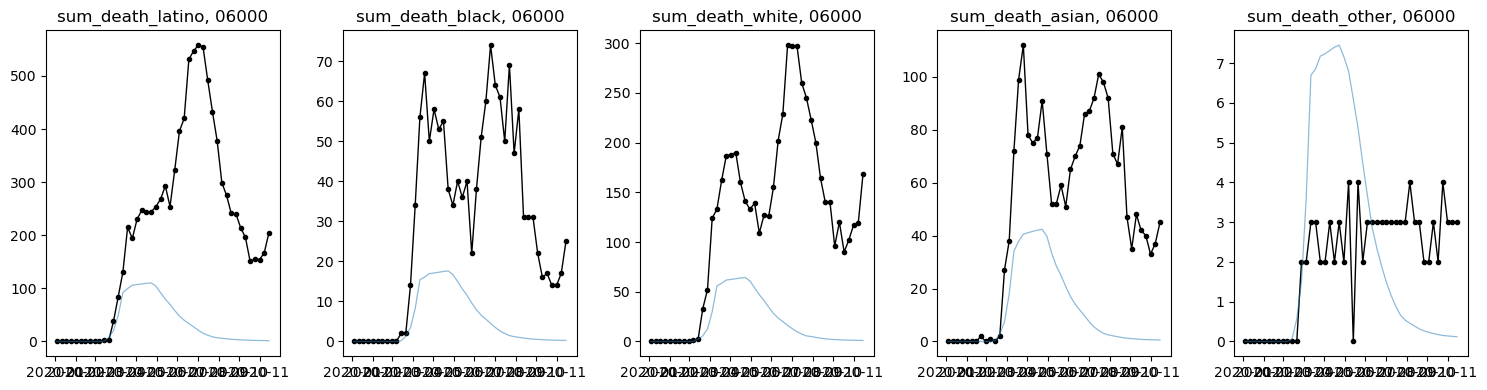

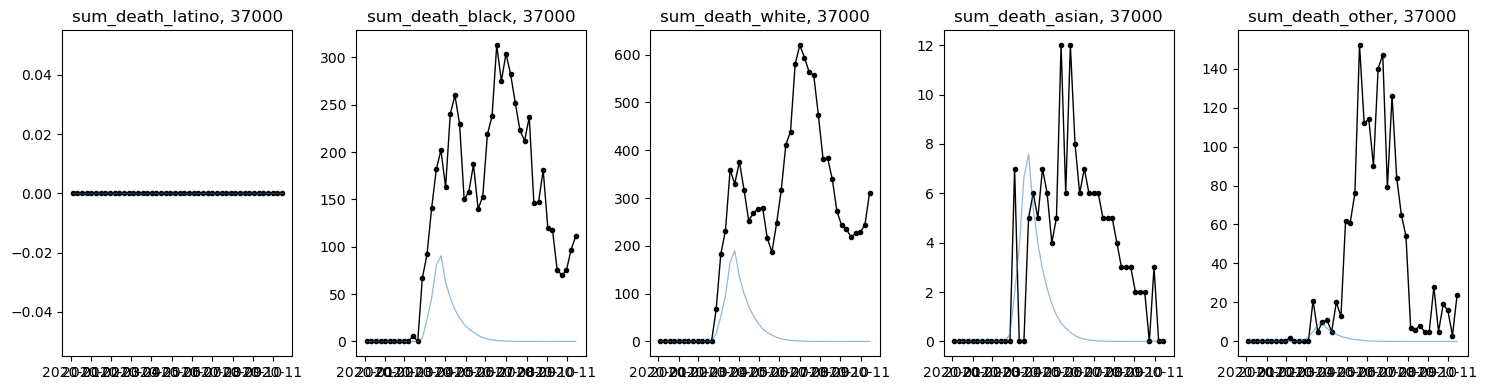

In [50]:
test_set = copy.deepcopy(p0[0])

# change all the values that have gempyor_inference.inferpar.pnames containing "IFR" to 0.1
for i, pname in enumerate(gempyor_inference.inferpar.pnames):
    this_sp = gempyor_inference.inferpar.subpops[i]
    if "IFR" in pname:
        test_set[i] *= 2
        if "black" in pname:
             test_set[i] *= 1.5
    if "latino_mod" in pname:
        test_set[i] *= 1.5
    if "white_mod" in pname:
        test_set[i] /= 1.5
    if "r0" in pname:
        test_set[i] *= 1
    if "local_variance" in pname:
        if this_sp == "37000":
            test_set[i] *= 2
gempyor_inference.set_save(True)
outcome_df = gempyor_inference.simulate_proposal(test_set)
modinf=gempyor_inference.modinf
inferpar=gempyor_inference.inferpar
loss=gempyor_inference.logloss
list_of_df=[outcome_df]


for j, subpop in enumerate(modinf.subpop_struct.subpop_names):
                fig, axes = plt.subplots(1, len(loss.statistics), figsize=(3 * len(loss.statistics), 4), sharex=True)
                
                gt_s = loss.gt[loss.gt["subpop"] == subpop].sort_index()
                first_date = max(gt_s.index.min(), list_of_df[0].index.min())
                last_date = min(gt_s.index.max(), list_of_df[0].index.max())
                gt_s = gt_s.loc[first_date:last_date].drop(["subpop"], axis=1).resample("W-SAT").sum()

                for i, (stat_name, stat) in enumerate(loss.statistics.items()):
                    ax = axes[i]
                    ax.plot(gt_s[stat.data_var], color="k", marker=".", lw=1)
                    for model_df in list_of_df:
                        model_df_s = (
                            model_df[model_df["subpop"] == subpop]
                            .drop(["subpop"], axis=1)
                            .loc[first_date:last_date]
                            .resample("W-SAT")
                            .sum()
                        )  # todo sub subpop here
                        ax.plot(model_df_s[stat.sim_var], lw=0.9, alpha=0.5)
                    # if True:
                    #        init_df_s = outcomes_df_ref[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                    ax.set_title(f"{stat_name}, {subpop}")
                fig.tight_layout()

In [4]:
df = gempyor.read_df("COVID19_Disparities/model_output/USA_inference_all/calib_R18/seir/003333122.calib_R18.seir.parquet")

In [34]:
a = df[df["mc_value_type"]=="prevalence"].drop([c for c in df.columns if ("mc" in c and "race" not in c)], axis=1).groupby(["date", "mc_race_strata"]).sum().reset_index()

<Axes: xlabel='date'>

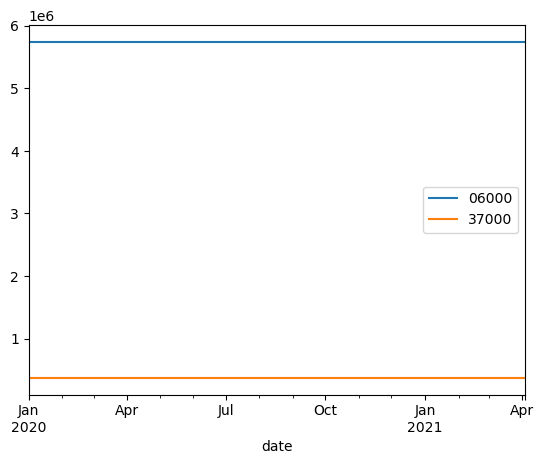

In [36]:
asian = a[a["mc_race_strata"]=="asian"]
asian.set_index("date").drop("mc_race_strata", axis=1).plot()

<Axes: xlabel='date'>

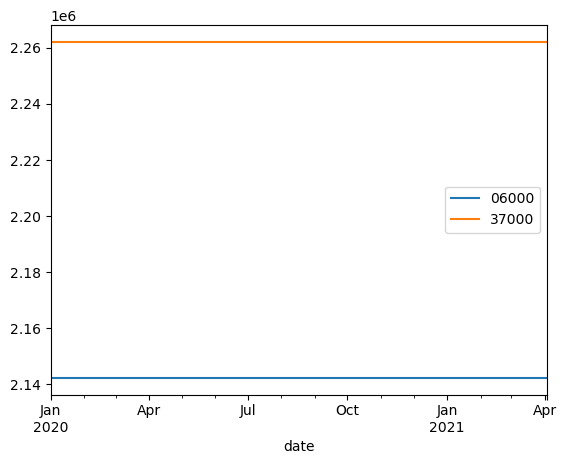

In [37]:
black = a[a["mc_race_strata"]=="black"]
black.set_index("date").drop("mc_race_strata", axis=1).plot()

In [30]:
black

,date,mc_race_strata,06000,37000
4,2020-01-01,black,0.000000e+00,0.000000e+00
5,2020-01-01,black,2.822285e+05,2.957676e+05
6,2020-01-01,black,4.030599e+05,5.401527e+05
7,2020-01-01,black,1.457098e+06,1.426172e+06
24,2020-01-02,black,0.000000e+00,0.000000e+00
...,...,...,...,...
206791,2021-04-03,black,3.373912e+03,7.489302e+02
206792,2021-04-03,black,5.039813e+03,9.360681e+02
206793,2021-04-03,black,2.788557e+05,2.906934e+05
206794,2021-04-03,black,4.005368e+05,5.395067e+05


In [17]:
gempyor_inference.perform_test_run()

test run successful 🎉, with logloss=-271424.0 including 0.0 for regularization (-0.0%) 


/Users/chadi/anaconda3/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


(           subpop  incidI_1dose_ALPHA_age0to17_asian  \
 date                                                   
 2020-01-01  06000                                0.0   
 2020-01-02  06000                                0.0   
 2020-01-03  06000                                0.0   
 2020-01-04  06000                                0.0   
 2020-01-05  06000                                0.0   
 ...           ...                                ...   
 2021-03-30  37000                                0.0   
 2021-03-31  37000                                0.0   
 2021-04-01  37000                                0.0   
 2021-04-02  37000                                0.0   
 2021-04-03  37000                                0.0   
 
             incidI_1dose_ALPHA_age0to17_black  \
 date                                            
 2020-01-01                                0.0   
 2020-01-02                                0.0   
 2020-01-03                                0.0   
 2020-0

In [ ]:
filename = f"{run_id}_backend.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, gempyor_inference.inferpar.get_dim())
gempyor_inference.set_silent(False)
with Pool(3) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, 
                                        gempyor_inference.inferpar.get_dim(), 
                                        gempyor_inference.get_logloss_as_single_number, 
                                        pool=pool,
                                        backend=backend, moves=[(emcee.moves.StretchMove(live_dangerously=True), 1)])
        state = sampler.run_mcmc(p0, niter, progress=True, skip_initial_state_check=True)

llik is -45729.70247489614
llik is -45842.41667236088
llik is -45976.52186496037


  0%|          | 0/4 [00:00<?, ?it/s]

llik is -45757.469693276245
llik is -45865.942736300945


 25%|██▌       | 1/4 [00:32<01:38, 32.96s/it]

llik is -45972.74954846854
llik is -45591.36506356454
llik is -45901.314939441305


 50%|█████     | 2/4 [01:05<01:05, 32.74s/it]

llik is -46074.59348286781
llik is -45890.32092923346
llik is -45969.61363397053


 75%|███████▌  | 3/4 [01:38<00:33, 33.00s/it]

llik is -45519.50216712484
llik is -45544.68410035816
llik is -45883.33418188836


In [ ]:
filename = f"{run_id}_backend.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(3, inferpar.get_dim())
with Pool(3) as pool:
        sampler = emcee.EnsembleSampler(3, 
                                        inferpar.get_dim(), 
                                        a.run, 
                                        pool=pool,
                                        backend=backend, moves=[(emcee.moves.StretchMove(live_dangerously=True), 1)])
        state = sampler.run_mcmc(p0[0:3,:], 5, progress=True, skip_initial_state_check=True)

llik: -46237.56540759982
llik: -46051.281202656246
llik: -45831.8716673561


  0%|          | 0/5 [00:00<?, ?it/s]

llik: -46099.484509051355
llik: -46195.55396420405


 20%|██        | 1/5 [00:33<02:13, 33.33s/it]

llik: -45909.410404363836


 20%|██        | 1/5 [00:34<02:17, 34.33s/it]


KeyboardInterrupt: 

In [ ]:
ds["incidH_18_49"].sum(dim="subpop", skipna=False).plot()

In [ ]:
ds["incidH_18_49"].resample(date="W-SAT").sum().plot.line(x="date");

In [ ]:
ds["incidH_18_49"].resample(date="W-SAT").sum(skipna=False).plot.line(x="date");

In [ ]:
ds["incidH_18_49"].resample(date="W-SAT", skipna=False).sum().plot.line(x="date");

In [ ]:
if False:
    log_loss.plot_gt(subplot=True);
    for reg_func, reg_config in log_loss.statistics['incidCase'].regularizations:
        print(reg_func,"\n", reg_config)

## Create the first gempyor object

In [ ]:
hosp.reset_index().set_index(["date","subpop"])
xr.Dataset.from_dataframe(hosp.reset_index().set_index(["date","subpop"]))

In [ ]:
raise ValueError

## Run EMCEE

In [ ]:
backend = emcee.backends.HDFBackend(filename)
with Pool(ncpu) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, 
                                    args=[snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters, True], 
                                    pool=pool,
                                    backend=backend,  moves=[(emcee.moves.StretchMove(live_dangerously=True), 1)])
    state = sampler.run_mcmc(None, (nsamples//nwalkers)+1, progress=True, skip_initial_state_check=True)

In [ ]:
    print(f"Done, mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")

In [ ]:
plt.plot(sampler.acceptance_fraction)

## Analysi

In [ ]:
filename = f"{run_id}_backend.h5"
sampler = emcee.backends.HDFBackend(filename, read_only=True)

In [ ]:
sampler.get_chain().shape

In [ ]:
# todo: restart form other shape...

In [ ]:
last_llik = sampler.get_log_prob()[-1,:]
good_slots = last_llik > (last_llik.mean()-1*last_llik.std())
print(f"there are {good_slots.sum()}/{len(good_slots)} good walkers... keeping these")

In [ ]:
fig, axes = plt.subplots(inferpar.get_dim()+1,2, figsize=(15, (inferpar.get_dim()+1)*2))

labels = list(zip(inferpar.pnames, inferpar.subpops))
samples = sampler.get_chain()

import seaborn as sns
def plot_chain(frompt,axes):
    ax = axes[0]

    ax.plot(np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0]),
                      sampler.get_log_prob()[frompt:,good_slots], "navy", alpha=.2, lw=1, label="good walkers")
    ax.plot(np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0]),
            sampler.get_log_prob()[frompt:,~good_slots], "tomato", alpha=.4, lw=1, label="bad walkers")
    ax.set_title("llik")
    #ax.legend()
    sns.despine(ax=ax, trim=False)
    ax.set_xlim(frompt, frompt+sampler.get_log_prob()[frompt:].shape[0])

    #ax.set_xlim(0, len(samples))

    for i in range(inferpar.get_dim()):
        ax = axes[i+1]
        ax.plot(np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0]),
                samples[frompt:,good_slots, i], "navy", alpha=.2, lw=1,)
        ax.plot(np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0]),
                samples[frompt:, ~good_slots, i], "tomato", alpha=.4, lw=1,)
        #ax.set_xlim(0, len(samples))
        ax.set_title(labels[i])
        #ax.yaxis.set_label_coords(-0.1, 0.5)
        sns.despine(ax=ax, trim=False)
        ax.set_xlim(frompt, frompt+samples[frompt:].shape[0])
        

    axes[-1].set_xlabel("step number");

plot_chain(0,axes[:,0])
plot_chain(3*samples.shape[0]//4,axes[:,1])
fig.tight_layout()

plt.savefig(f"{run_id}_chains.pdf")

In [ ]:
good_samples =  sampler.get_chain()[:,good_slots,:]
good_samples.shape

In [ ]:
step_number = -1
exported_samples = np.empty((nsamples,ndim))
for i in range(nsamples):
    exported_samples[i,:] = good_samples[step_number - nthin*(i//(good_slots.sum())) ,i%(good_slots.sum()),:] # parentesis around i//(good_slots.sum() are very important

In [ ]:
position_arguments = [snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters, True]

with Pool(ncpu) as pool:
    results = pool.starmap(log_prob, [(sample, *position_arguments) for sample in exported_samples])

In [ ]:
np.mean(sampler.get_log_prob()[-1,:])

In [ ]:
#import concurrent.futures
#
def evaluate(proposals, k):
    proposal = proposals[k]
    snpi_df_mod, hnpi_df_mod = input_proposal(proposal, snpi_df_ref, hnpi_df_ref, fitted_params, ndim)

    outcomes_df = run_simulation(snpi_df_mod, 
                                hnpi_df_mod,
                                modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters)
    return outcomes_df
#
#with concurrent.futures.ThreadPoolExecutor(max_workers=nwalkers) as executor:
#    # Map the function to the list of k values in parallel
#    results = list(executor.map(lambda k_val: evaluate(samples[-1,:,:], k_val), np.arange(nwalkers)))
#

results = []
for k in range(nwalkers):
    results.append(evaluate(samples[-1,:,:], k))

In [ ]:
results

In [ ]:
results = []
for fn in gempyor.utils.list_filenames(folder="model_output/", filters=[run_id,"hosp.parquet"]):
    if "000000000" not in fn:
        df = gempyor.read_df(fn)
        #raise ValueError
        df["date"] = df["time"]
        df = df.set_index("date")
        results.append(df)

In [ ]:
results[0].index.max()

In [ ]:
fig, axes = plt.subplots(len(statistics),len(subpop_names), figsize=(5*len(subpop_names), 3*len(statistics)), sharex=True, dpi=300)
for j, subpop in enumerate(modinf.subpop_struct.subpop_names):
        gt_s = gt[gt["subpop"]==subpop].sort_index()
        first_date = max(gt_s.index.min(),results[0].index.min())
        last_date = min(gt_s.index.max(), results[0].index.max())
        gt_s = gt_s.loc[first_date:last_date].drop(["subpop"],axis=1).resample("W-SAT").sum()
        
        for i, (key, value) in enumerate(statistics.items()):
                ax = axes[i,j]
                ax.plot(gt_s[value], color='k', marker='.', lw=1)
                for model_df in results:
                        model_df_s = model_df[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[first_date:last_date].resample("W-SAT").sum() # todo sub subpop here
                        ax.plot(model_df_s[key],  lw=.9, alpha=.5)
                #if True:
                #        init_df_s = outcomes_df_ref[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                ax.set_title(f"{value}, {subpop}")
fig.tight_layout()
plt.savefig(f"{run_id}_results.pdf")

In [ ]:
gt_s.isna().sum()

In [ ]:
gt_s.plot(subplots=True)

In [ ]:
gt_s["incidH_65_100"]

In [ ]:
gt_s

In [ ]:
emcee.__version__

In [ ]:
import corner

In [ ]:
#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=30, thin=2,flat=True) #discard=100, thin=15, 
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels, #truths=[m_true, b_true, np.log(f_true)]
);